## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [1]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1


Processing /home/thdoa/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e/networkx-2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8f/b7/f329cfdc75f3d28d12c65980e4469e2fa373f1953f5df6e370e84ea2e875/decorator-4.4.1-py2.py3-none-any.whl


In [2]:
import pkg_resources
pkg_resources.require("networkx==2.1")

import networkx as nx
nx.__version__

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid_and_edges
import numpy.linalg as LA
%matplotlib inline 

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

In [6]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)
print(data.shape)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]
(3845, 6)


Starting and goal positions in *(north, east)*.

In [7]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [8]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [9]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

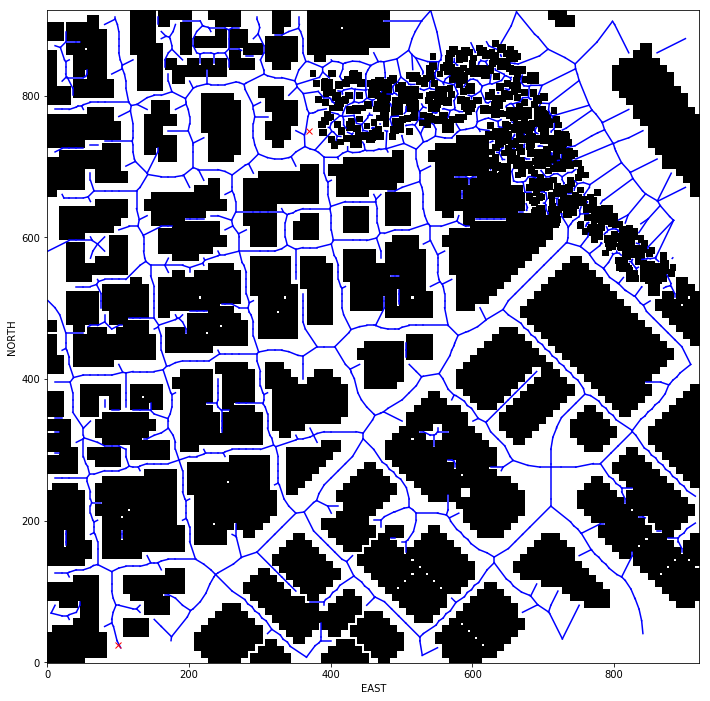

In [10]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [24]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()

for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)
    

You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [41]:
from queue import PriorityQueue

def heuristic(n1, n2):
    # Define a heuristic using euclidean distance.
    return LA.norm(np.array(n2) - np.array(n1))

def a_star(G, h, s, goal):
    queue = PriorityQueue()
    queue.put((0, s))
    visited = set(s)
    
    branch = {}
    found = False    
    while not queue.empty():
        x = queue.get()[1]
        if x == s:
            accum_cost = 0.0
        else:
            accum_cost = branch[x][0]
        
        if x == goal:
            print('Path found!')
            found = True
            break
        else:
            for y in G.neighbors(x):
                cost = accum_cost + G[x][y]['weight']
                est_cost = cost + h(y, goal)
                
                if y not in visited:
                    visited.add(y)
                    branch[y] = (cost, x)
                    queue.put((est_cost, y))
    
    path = []
    cost = 0
    if found:
        # retrace
        n = goal
        cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != s:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(s)
    else:
        print('Failed to find path!')
    return path[::-1], cost


### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

In [39]:
def closest_point(graph, x):
    x_closest = None
    min_dist = 100000
    for y in graph.nodes:        
        d = LA.norm(np.array(y) - np.array(x))
        if d < min_dist:
            x_closest = y
            min_dist = d
    return x_closest

graph_start_ne = closest_point(G, start_ne)
graph_goal_ne = closest_point(G, goal_ne)
print(start_ne, goal_ne)
print(graph_start_ne, graph_goal_ne)

(25, 100) (750.0, 370.0)
(20.7611, 103.26850000000002) (748.7187188843021, 364.4144680930903)


In [42]:
path, cost = a_star(G, heuristic, graph_start_ne, graph_goal_ne)
print(path)

Path found!
[(20.7611, 103.26850000000002), (30.7611, 98.26850000000002), (50.7611, 93.26850000000002), (55.7611, 90.76850000000002), (60.7611, 90.76850000000002), (70.7611, 92.76850000000002), (80.7611, 96.76850000000002), (90.7611, 92.76850000000002), (100.7611, 90.76850000000002), (110.7611, 90.76850000000002), (128.2611, 90.76850000000002), (133.2611, 100.76850000000002), (135.7611, 110.76850000000002), (135.7611, 120.76850000000002), (135.7611, 130.76850000000002), (138.2611, 140.76850000000002), (140.7611, 145.76850000000002), (140.7611, 150.76850000000002), (140.7611, 155.76850000000002), (143.2611, 160.76850000000002), (145.7611, 170.76850000000002), (145.7611, 180.76850000000002), (145.7611, 209.10183333333333), (138.7611, 220.7685), (130.7611, 230.7685), (124.09443333333334, 237.43516666666667), (126.4753857142857, 240.7685), (138.9429181818182, 262.58668181818183), (148.03382727272728, 273.49577272727277), (148.45349378689895, 273.8454948224158), (155.76113750001562, 295.768

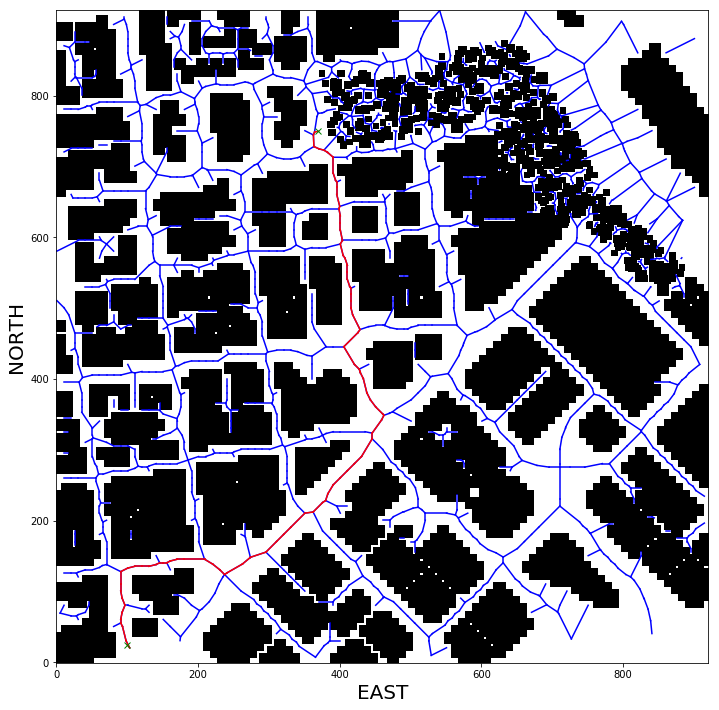

In [44]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.plot([start_ne[1], graph_start_ne[1]], [start_ne[0], graph_start_ne[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
    
plt.plot([goal_ne[1], graph_goal_ne[1]], [goal_ne[0], graph_goal_ne[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'gx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

[our solution](/notebooks/Graph-Search-Solution.ipynb)